## Fast iterations to improve to analyze the data

### Working with cleaned data

Now we have cleaned some data, we can train again, using more advanced techniques.

We will start by a simple training again, to see if the cleaning was successful.

In [1]:
from fastcore.all import *
from fastai.vision.all import *

In [2]:
cheese = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)
dls = cheese.dataloaders("working/which_cheese_cleaned")
learn = vision_learner(dls, resnet18, metrics=accuracy)

In [3]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.137223,2.343409,0.326829,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.324481,1.571146,0.570732,00:02
1,1.581721,1.212596,0.643902,00:02
2,1.146727,1.148679,0.678049,00:02


We now roughly archieve 68% accuracy. Let's train further to see how far when can get.

In [14]:
learn.fine_tune(13)

epoch,train_loss,valid_loss,accuracy,time
0,0.523904,1.073870,0.717073,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.314336,1.042765,0.721951,00:02
1,0.260081,0.991794,0.741463,00:02
2,0.203073,0.943358,0.741463,00:02
3,0.158532,0.913470,0.756098,00:02
4,0.141772,0.872876,0.751220,00:02
5,0.121437,0.816914,0.751220,00:02
6,0.101683,0.836497,0.765854,00:02
7,0.085780,0.845604,0.751220,00:02
8,0.071734,0.842247,0.760976,00:02
9,0.062432,0.823996,0.765854,00:02


We seem to have hit a wall at 76% accuracy as early as iteration 6.

#### A word on the choice of metrics

Earlier I chose `accuracy` as the metric. Let’s examine our data to see if the choice is still valid.

In [5]:
pd.Series([dls.vocab[o[1]] for o in dls.train_ds]).value_counts()

Fourme d’Ambert          48
Chabichou du Poitou      47
Mimolette                44
Pont-l’Évêque            44
Brie de Meaux            43
Comté                    41
Tomme de Savoie          41
Cantal                   40
Pélardon                 40
Reblochon                39
Valençay                 39
Bleu d’Auvergne          38
Neufchâtel               37
Livarot                  36
Selles-sur-Cher          35
Camembert                34
Époisses de Bourgogne    33
Manchego                 32
Munster                  32
Gruyere                  29
Roquefort                27
Banon                    24
Name: count, dtype: int64

As I mentioned earlier, the dataset is no longer balanced. However, it is also not imbalanced, as the imbalance is 2:1 and not 1:10, an order of magnitude. We stick with `accuracy`.

### Data Augmentation

We do not have many images in the data. Therefore, we will use data augmentation and move from squishing to `RandomResizedCrop`.

In [15]:
cheese_augmented = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(192, min_scale=0.3),
    batch_tfms=aug_transforms(mult=2))

dls = cheese_augmented.dataloaders("working/which_cheese_cleaned")

> **Note:**
I choose here to override the variables. A standard programming approach would use new variables. However, the learner reserves memory on the GPU. We will hit an `out of memory` error.
One option is to delete the previous variable and free up the memory. The other option, which I chose here, is to override it with a new learner. This override implicitly deleted the old learner.


In [17]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

We will pull another trick and use a better learning rate.

/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, 

SuggestedLRs(valley=0.0014454397605732083)

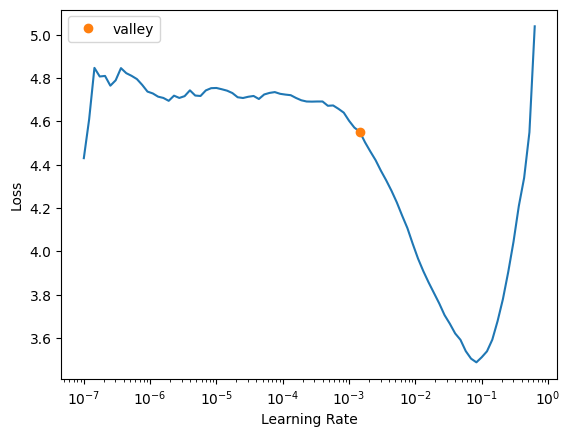

In [11]:
learn.lr_find()

In [18]:
learn.fine_tune(16, 1.44e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.298504,2.772096,0.278049,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.559263,2.476911,0.331707,00:02
1,3.395612,2.182159,0.370732,00:02
2,3.096542,1.812795,0.492683,00:02
3,2.789779,1.489513,0.570732,00:02
4,2.507986,1.255989,0.629268,00:02
5,2.255753,1.103503,0.687805,00:02
6,1.996111,1.050033,0.726829,00:02
7,1.788129,0.995375,0.741463,00:02
8,1.612162,0.972283,0.741463,00:02
9,1.448160,0.921064,0.736585,00:02


In [19]:
learn.fine_tune(6, 1.44e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.824386,0.848143,0.780488,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.778520,0.854400,0.780488,00:02
1,0.784403,0.840095,0.770732,00:02
2,0.752580,0.833080,0.760976,00:02
3,0.711079,0.824473,0.775610,00:02
4,0.661186,0.804503,0.760976,00:02
5,0.619942,0.800512,0.765854,00:02


In [20]:
learn.fine_tune(6, 1.44e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.536938,0.783610,0.775610,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.553907,0.786242,0.775610,00:02
1,0.547560,0.848543,0.765854,00:02
2,0.524134,0.848381,0.756098,00:02
3,0.499666,0.811153,0.780488,00:02
4,0.473074,0.783625,0.780488,00:02
5,0.465626,0.781733,0.785366,00:02


The training advanced more slowly. It seems to have hit the same block at 76%, 77%. Only after 12 more iterations, we seem to have converged on a path with over 78%. The Validation loss is only going down after 6 iterations, showing convergence issues of the gradient descent.

Let’s look at the solution

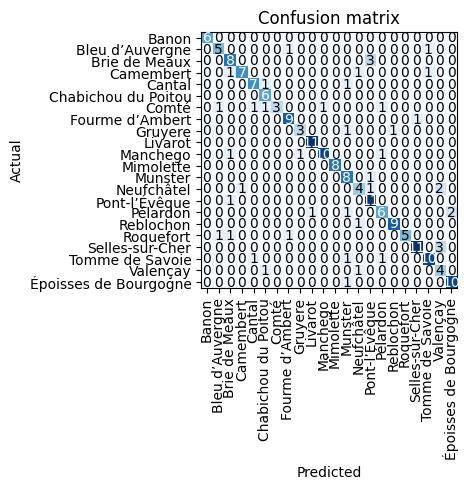

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

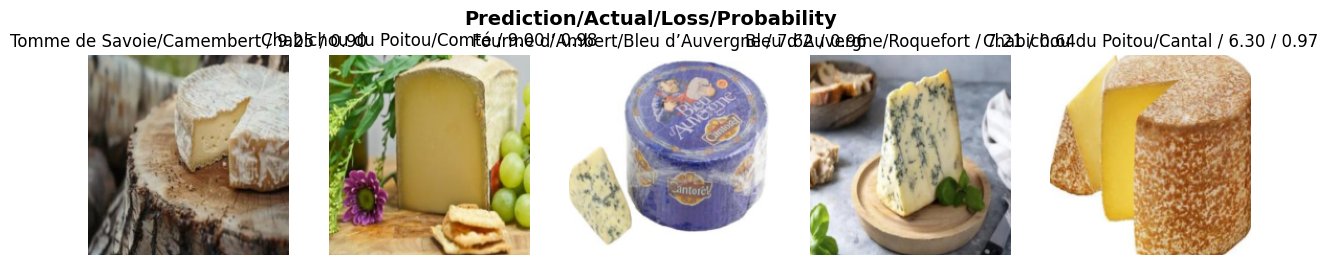

In [22]:
interp.plot_top_losses(5, nrows=1)

The `fourme d'ambert` uncertainty has almost vanished. The top losses are from images that have slipped my cleaning efforts and are indeeed misleading.

### Label smoothing

As the data still has a lot of noise, we can try label smoothing. `Labelsmoothing` assumes a natural uncertainty and no label can have 100%. Instead, Label smoothing redistributes a small portion of the correct class’s probability across all classes to prevent overconfidence and improve generalization.

We will start with 28 iterations.

In [23]:
from fastai.losses import LabelSmoothingCrossEntropy

learn = vision_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())


/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, 

SuggestedLRs(valley=0.00363078061491251)

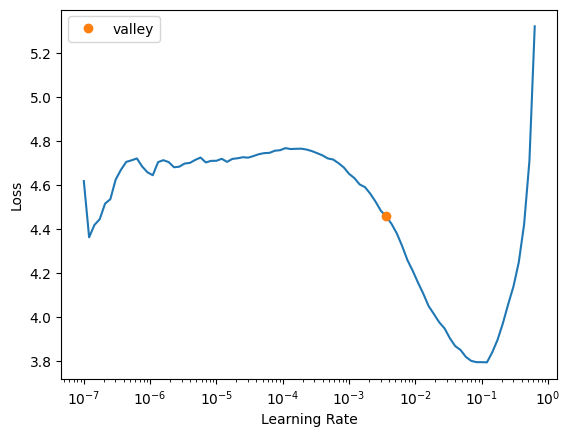

In [24]:
learn.lr_find()

In [25]:
learn.fine_tune(28, 3.6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.273853,2.742732,0.307317,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.933313,2.152079,0.429268,00:02
1,2.757924,1.957854,0.531707,00:02
2,2.600373,1.795183,0.595122,00:02
3,2.414058,1.652869,0.648780,00:02
4,2.251830,1.555603,0.692683,00:02
5,2.109990,1.569267,0.702439,00:02
6,1.985083,1.525316,0.717073,00:02
7,1.878232,1.548784,0.717073,00:02
8,1.782599,1.508083,0.726829,00:02
9,1.692580,1.468358,0.746341,00:02


Starting at iteration 13, issues emerged with the loss function. We observed an accuracy of approximately 81%. Yet, our accuracy is just 79%, despite the reduced loss


### Summary

`Data augmentation` and `Label Smoothing` both help with very noisy data and a low amount of samples. We got the accuracy from 76% to 81%.